In [ ]:
!nvidia-smi

Wed Jun 28 12:57:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Creating helper functions

We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-28 12:57:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-28 12:57:08 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves, walk_through_dir, unzip_data, create_tensorboard_callback,compare_historys, make_confusion_matrix

In [ ]:
# Food Data
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-06-28 12:57:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  37.1MB/s    in 42s     

2023-06-28 12:57:53 (36.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('101_food_classes_10_percent.zip')

In [ ]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '10

In [ ]:
# becomeone with data
# try viewing random images from the train directory and differnt classes

In [ ]:
import tensorflow as tf

In [ ]:
## Set up data inputs

IMAGE_SIZE = (224,224)


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode='categorical',
                                                                    image_size=IMAGE_SIZE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode='categorical',
                                                                  image_size=IMAGE_SIZE,
                                                                  shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
## # Create checkpoint callback to save model for later use

checkpoint_path = '101_class_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)


In [ ]:
# create data augmentation layer to incorporate directlyinto model layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomZoom(0.2),
            layers.RandomHeight(0.2),
            layers.RandomWidth(0.2),
            layers.RandomRotation(0.2),
            #preprocessing.Rescaling(1./255.)
], name='data_augmentation')

In [ ]:
# create Model

# create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Set up model archetecture
input_shape=IMAGE_SIZE+(3,)
inputs = tf.keras.layers.Input(shape=(input_shape), name='input_layer')

# augmentation
x = data_augmentation(inputs) # only happens during training

# pass the inputs through base_mode;
x = base_model(x, training=False) # put the base_model in inference mode so weights don't get updated

# global average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_layer')(x)

# output layer
outputs = tf.keras.layers.Dense(len(train_dataset.class_names), activation='softmax', name='output_layer')(x)

# create model
model_1 = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# Check the model summary of Tranfer learning feature extraction model we just built
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_layer (GlobalAve  (None, 1280)             0         
 ragePooling2D)                                                  
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
# define tensorboard callback
tb_dir_name = 'transfer_learning'
tensorboard_callback = create_tensorboard_callback(tb_dir_name, experiment_name='101_10_percent_data_fe')

initial_epochs = 5

# fit the model
history_all_classes_10_percent = model_1.fit(train_dataset,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_dataset),
                        validation_data=test_dataset,
                        validation_steps=int(0.15 * len(test_dataset)), #validated only on 15% of testdata
                        callbacks=[checkpoint_callback, tensorboard_callback])

Saving TensorBoard log files to: transfer_learning/101_10_percent_data_fe/20230628-125820


Epoch 1/5
237/237 [==============================] - 117s 426ms/step - loss: 3.3699 - accuracy: 0.2775 - val_loss: 2.5828 - val_accuracy: 0.4039
Epoch 2/5
237/237 [==============================] - 77s 324ms/step - loss: 2.2161 - accuracy: 0.4914 - val_loss: 2.0831 - val_accuracy: 0.4947
Epoch 3/5
237/237 [==============================] - 67s 280ms/step - loss: 1.8390 - accuracy: 0.5661 - val_loss: 1.9307 - val_accuracy: 0.5140
Epoch 4/5
237/237 [==============================] - 60s 253ms/step - loss: 1.6180 - accuracy: 0.6054 - val_loss: 1.8287 - val_accuracy: 0.5312
Epoch 5/5
237/237 [==============================] - 58s 244ms/step - loss: 1.4752 - accuracy: 0.6391 - val_loss: 1.8108 - val_accuracy: 0.5265


In [ ]:
# evaluate on whol etestdata
results_all_classes_10_percent= model_1.evaluate(test_dataset)
results_all_classes_10_percent

790/790 [==============================] - 71s 89ms/step - loss: 1.5863 - accuracy: 0.5804


[1.5863436460494995, 0.5803960561752319]

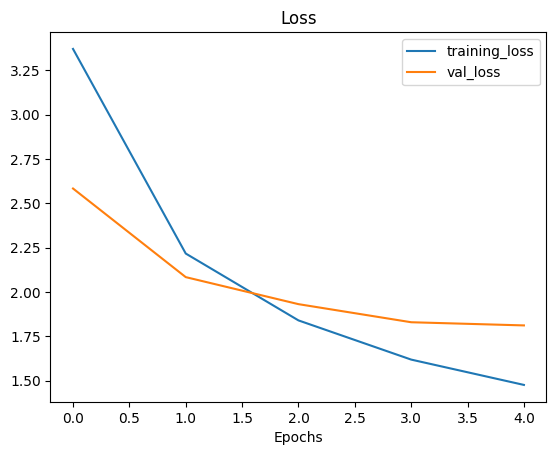

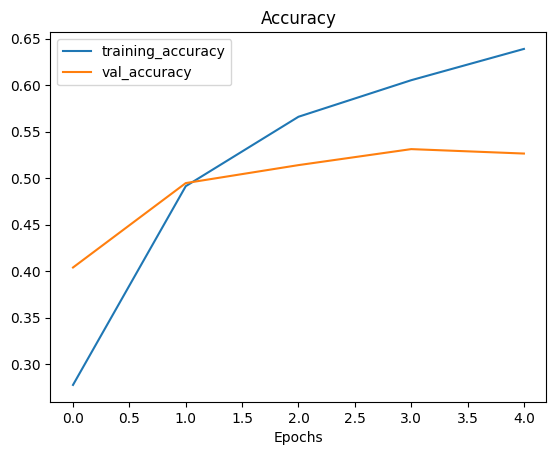

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

### Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [ ]:
#unfreeze all layer True
base_model.trainable = True

# freeze all layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [ ]:
# recompile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
for layer in model_1.layers:
   print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_layer True
output_layer True


In [ ]:
for i, layer in enumerate(model_1.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
## fine tune
fine_tune_epochs = 10 # total epochs

history_all_classes_10_percent_fine_tune = model_1.fit(train_dataset,
            epochs=fine_tune_epochs,
            validation_data=test_dataset,
            validation_steps=int(0.15 * len(test_dataset)),
            initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 67s 239ms/step - loss: 1.2439 - accuracy: 0.6743 - val_loss: 1.7285 - val_accuracy: 0.5421
Epoch 6/10
237/237 [==============================] - 54s 226ms/step - loss: 1.1345 - accuracy: 0.7030 - val_loss: 1.7285 - val_accuracy: 0.5485
Epoch 7/10
237/237 [==============================] - 71s 300ms/step - loss: 1.0554 - accuracy: 0.7216 - val_loss: 1.7074 - val_accuracy: 0.5506
Epoch 8/10
237/237 [==============================] - 70s 291ms/step - loss: 0.9816 - accuracy: 0.7339 - val_loss: 1.7098 - val_accuracy: 0.5501
Epoch 9/10
237/237 [==============================] - 64s 266ms/step - loss: 0.9367 - accuracy: 0.7456 - val_loss: 1.7077 - val_accuracy: 0.5530
Epoch 10/10
237/237 [==============================] - 60s 252ms/step - loss: 0.8728 - accuracy: 0.7683 - val_loss: 1.7136 - val_accuracy: 0.5490


In [ ]:
results_all_classes_10_percent_fine_tune = model_1.evaluate(test_dataset)

790/790 [==============================] - 84s 106ms/step - loss: 1.5011 - accuracy: 0.6025


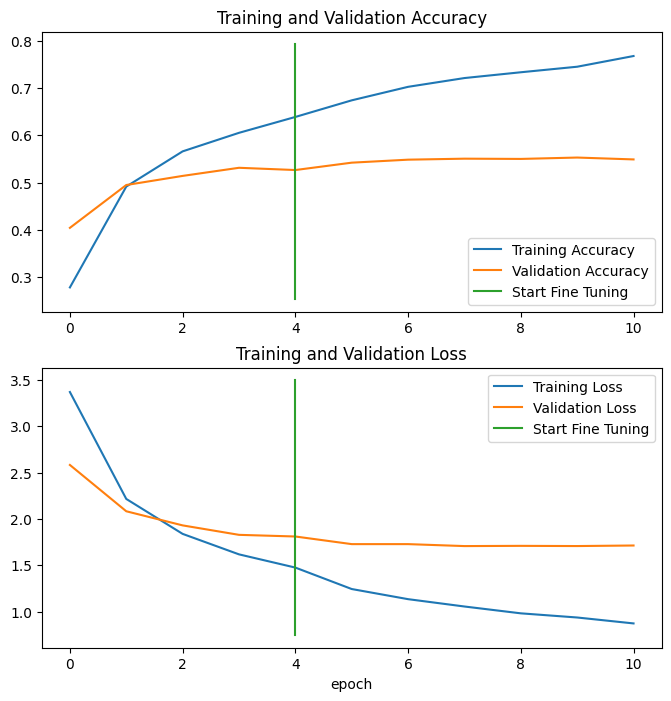

In [ ]:
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

In [ ]:
# Save our fine tuned model and load model

model_1.save('/content/drive/MyDrive/ColabNotebooks/udemy_tf/transfer_learning3_model_1')

TypeError: ignored

In [ ]:
# load the saved model
loaded_model_1 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/udemy_tf/transfer_learning3_model_1')

In [ ]:
# verify the loaded model results
loaded_model_results = loaded_model_1.evaluate(test_dataset)

In [ ]:
results_all_classes_10_percent_fine_tune

## Evaluating prediction of fine tuned model on all classes

In [ ]:
# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

--2023-06-28 13:22:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  22.6MB/s    in 2.0s    

2023-06-28 13:22:45 (22.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [ ]:
result_downloaded_model = model.evaluate(test_dataset)
result_downloaded_model

# the result is general, we would like verify  how our model performs on each target class

790/790 [==============================] - 70s 86ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Make prediction with our trained model

In [ ]:
# make prediction
preds_probs = model.predict(test_dataset, verbose=1)

790/790 [==============================] - 67s 82ms/step


In [ ]:
len(test_dataset)

790

In [ ]:
# How many predictions arethere?
len(preds_probs)

25250

In [ ]:
# Whats the shape of prediction
preds_probs.shape

(25250, 101)

In [ ]:
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [ ]:
# what does oen prediction look like
preds_probs[0], len(preds_probs), sum(preds_probs)

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What is the prediction probabilities look like:\n{preds_probs[0]}")
print(f"The class with the highest probability: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What is the prediction probabilities look like:
[5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.05

In [ ]:
preds_probs[0].argmax()

52

In [ ]:
tf.argmax(preds_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=52>

In [ ]:
np.argmax(preds_probs[0])

52

In [ ]:
train_dataset.class_names[preds_probs[0].argmax()]

'gyoza'

In [ ]:
#predicted label class
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many prediction we have
len(pred_classes)

25250

In [ ]:
# Now we need to get y_true, ground truth
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# to get labels from test_dataset, we need to unravel the dataset

y_labels=[]
for images, labels in test_dataset.unbatch(): ## we use unbatch the unravel the dataset
    y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there
len(y_labels)

25250

In [ ]:
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.6077623762376237

In [ ]:
result_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
import numpy as np
np.isclose(result_downloaded_model[1], sklearn_acc)

True

## Creating Confusion Matrix

In [ ]:
class_names = test_dataset.class_names

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix



# updating the custom confusion matrix functin
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## rotate x_ticks and make it bigger
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [ ]:
from sklearn.metrics import classification_report

classification_report_dict = classification_report(y_true=y_labels,
                              y_pred=pred_classes,
                              output_dict=True)

In [ ]:
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [ ]:
# Create f1 score dictionary
class_f1_scores={}

for k, v in classification_report_dict.items():
    if k=='accuracy':
        break
    else:
        class_f1_scores[class_names[int(k)]] =v['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# sort dictionary

import pandas as pd

f1_scores = pd.DataFrame({'class_names':list(class_f1_scores.keys()),
                          'f1_score':list(class_f1_scores.values())}).sort_values('f1_score', ascending=True)

In [ ]:
f1_scores[:-10]

class_names  f1_score
0             apple_pie  0.240566
39            foie_gras  0.297491
77            pork_chop  0.308756
22     chocolate_mousse  0.329159
56     huevos_rancheros  0.339833
..                  ...       ...
76                pizza  0.780876
32            dumplings  0.785579
90  spaghetti_bolognese  0.788155
7              bibimbap  0.790890
54    hot_and_sour_soup  0.810345

[91 rows x 2 columns]

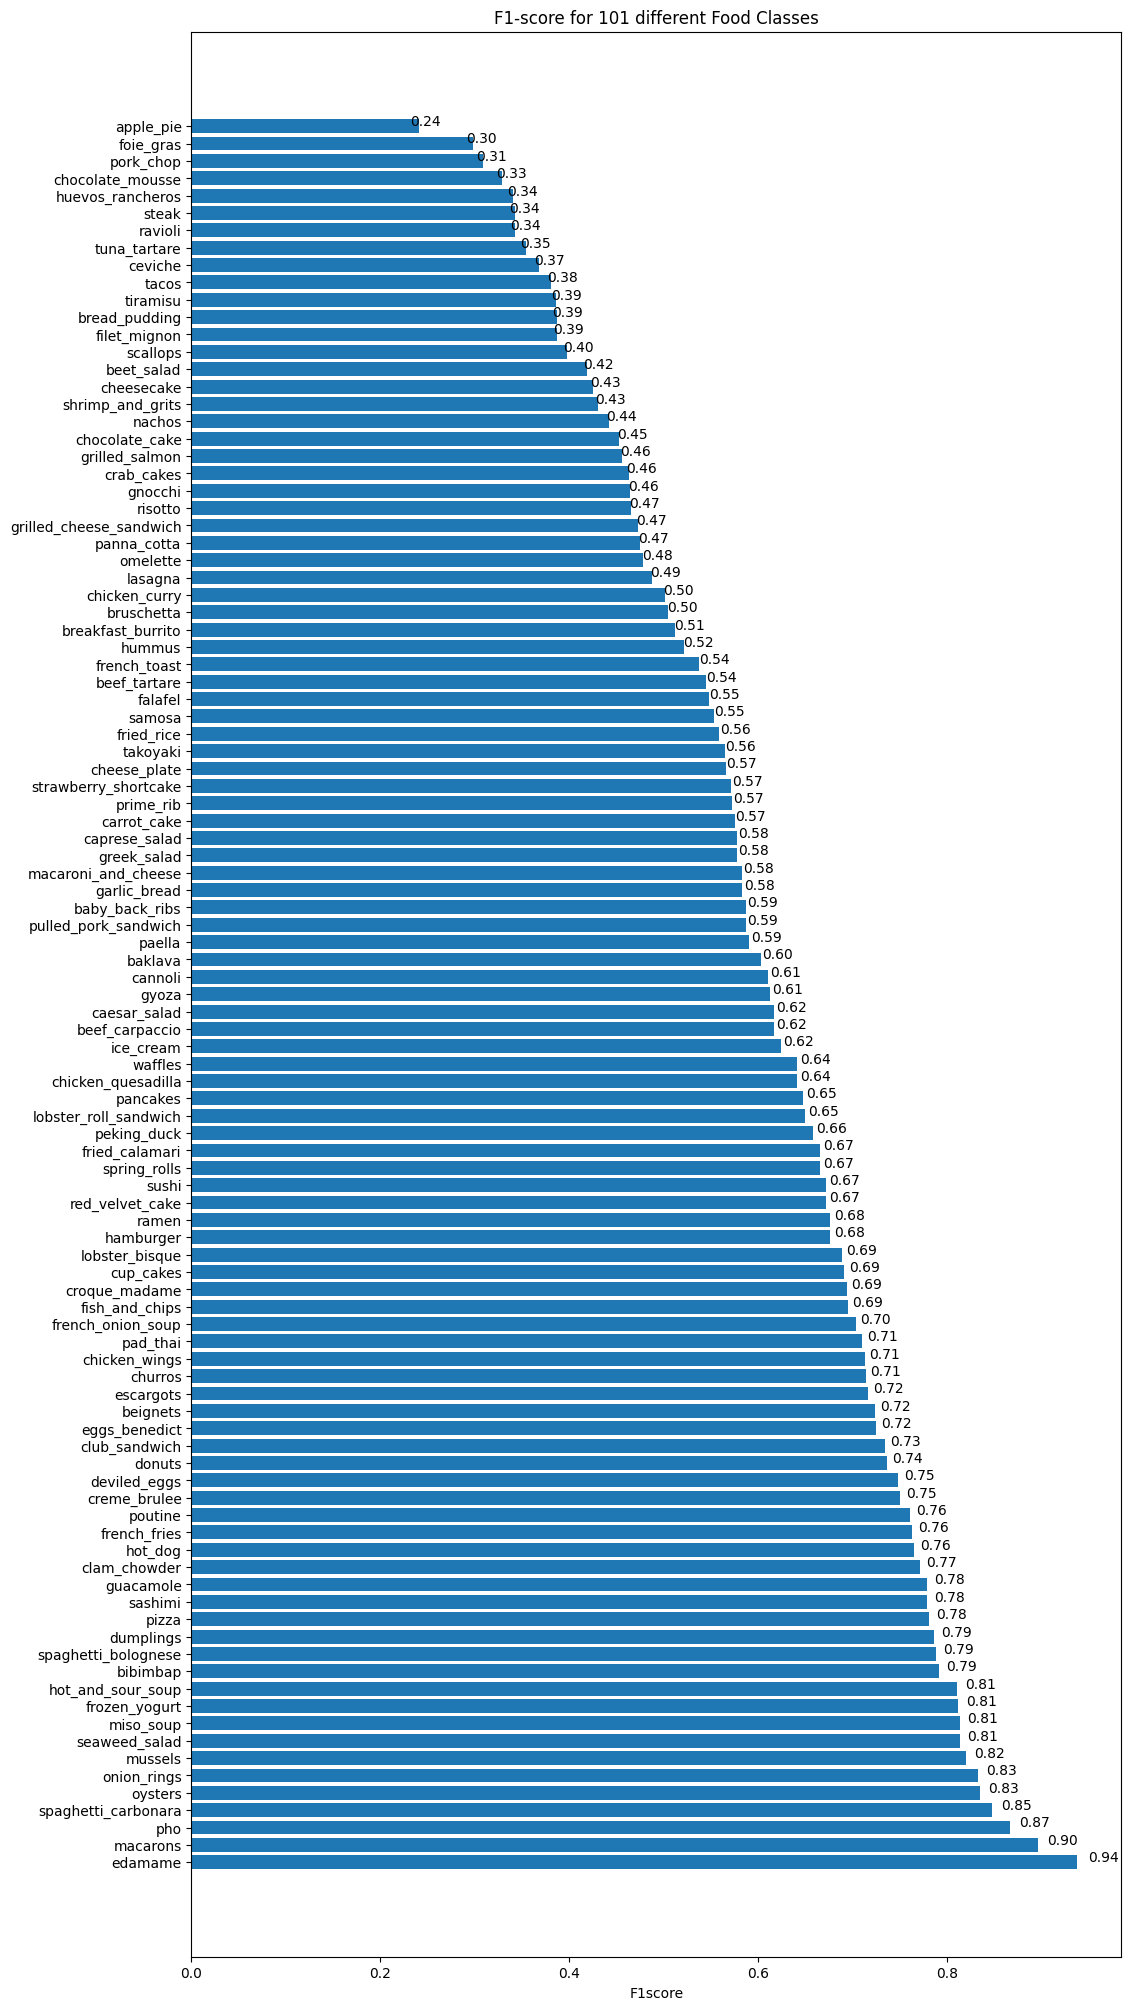

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1_score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1score')
ax.set_title('F1-score for 101 different Food Classes')
ax.invert_yaxis()

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Now that's a good looking graph! I mean, the text positioning could be improved a little but it'll do for now.

Can you see how visualizing our model's predictions gives us a completely new insight into its performance?

A few moments ago we only had an accuracy score but now we've got an indiciation of how well our model is performing on a class by class basis.

It seems like our model performs fairly poorly on classes like `apple_pie` and `ravioli` while for classes like `edamame` and `pho` the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

> 🛠 **Exercise:** Visualize some of the most poor performing classes, do you notice any trends among them?


### Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [ ]:
def load_and_prep_img(filename, img_size=224, scale=True):
    """
    Reads in an img from filename into a tensor and reshapes its in specified shape


    Arggs:
      filename: path to target image
      img_size: target image size
      scale(bool):

    Returns:
      Preprocessed image tensor of shape [img_size, img_size, 3]
    """

    # read image
    img = tf.io.read_file(filename)

    # decode image
    img = tf.io.decode_image(img, channels=3)

    #resize image
    img = tf.image.resize(img, [img_size, img_size])

    # scale? yes/no
    if scale:
        #rescale images
        return img/255.
    else:
        return img #EfficientNet don't need prior rescaling of image

Image loading and preprocessing function ready.

Now let's write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

101_food_classes_10_percent/test/eggs_benedict/2605435.jpg
1/1 [==============================] - 0s 27ms/step


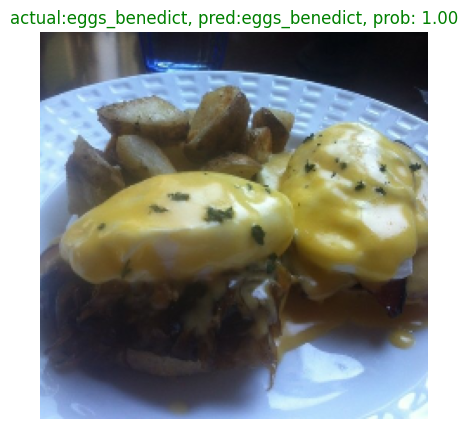

101_food_classes_10_percent/test/samosa/3065558.jpg
1/1 [==============================] - 0s 69ms/step


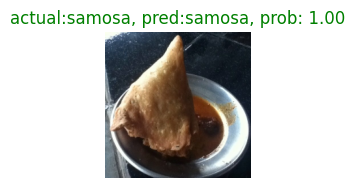

101_food_classes_10_percent/test/greek_salad/2517209.jpg
1/1 [==============================] - 0s 70ms/step


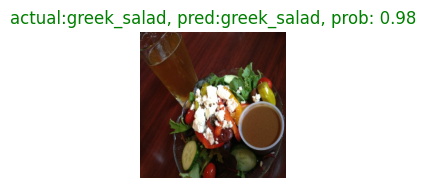

In [ ]:
import random, os

class_names = test_dataset.class_names

plt.figure(figsize=(17,10))
for i in range(3):
    # Choose random image
    target_class = random.choice(class_names)
    file_name = random.choice(os.listdir(test_dir+'/'+target_class))
    file_path = os.path.join(test_dir, target_class, file_name)
    print(file_path)
    # Preprocess image for model
    img = load_and_prep_img(file_path, scale=False)
    img = tf.expand_dims(img, 0)

    pred_prob = model.predict(img)
    pred_class = class_names[pred_prob.argmax()]
    # print(pred_prob)
    # print(pred_prob.shape)
    # print(pred_class)
    # print(img.shape)
    plt.subplot(1, 3, i+1)
    img = np.squeeze(img)
    plt.imshow(img/255.)
    if target_class==pred_class:
        title_color='g'
    else:
        title_color='r'
    plt.title(f'actual:{target_class}, pred:{pred_class}, prob: {pred_prob.max():.2f}', c=title_color)
    plt.axis(False)
    plt.show()


### Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# Get all of the image file paths in the test dataset using the list_files() method.
filepaths=[]

for filepath in test_dataset.list_files('101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
    filepaths.append(filepath.numpy())


filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# Create a pandas DataFrame of the image filepaths, ground truth labels,
# prediction classes, max prediction probabilities, ground truth class names and predicted class names.

import pandas as pd
pred_df = pd.DataFrame({'filepath':filepaths,
                        'y_true':y_labels,
                        'pred_class':pred_classes,
                        'pred_conf':preds_probs.max(axis=1), # get the maximum prediction probability value
                        'y_true_class_names':[class_names[i] for i in y_labels],
                        'y_pred_class_names':[class_names[i] for i in pred_classes]})

pred_df.head()

filepath  y_true  pred_class  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0          52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0           0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0           0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0          80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0          79   

   pred_conf y_true_class_names    y_pred_class_names  
0   0.847419          apple_pie                 gyoza  
1   0.964017          apple_pie             apple_pie  
2   0.959259          apple_pie             apple_pie  
3   0.658606          apple_pie  pulled_pork_sandwich  
4   0.367900          apple_pie             prime_rib

In [ ]:
# 3. Create a column is prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["pred_class"]
pred_df.head()

filepath  y_true  pred_class  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0          52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0           0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0           0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0          80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0          79   

   pred_conf y_true_class_names    y_pred_class_names  pred_correct  
0   0.847419          apple_pie                 gyoza         False  
1   0.964017          apple_pie             apple_pie          True  
2   0.959259          apple_pie             apple_pie          True  
3   0.658606          apple_pie  pulled_pork_sandwich         False  
4   0.367900          apple_pie             prime_rib         False

In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf',ascending=False)
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

filepath  y_true  pred_class  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87          29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0         100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61          53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94          83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85          92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98          83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10          61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22          21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71          65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95          86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72          67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46          10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43          68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94          83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4           5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43          68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95          86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29          83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52          92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43          68   

       pred_conf     y_true_class_names     y_pred_class_names  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

In [ ]:
# initialize start index
start_index=0

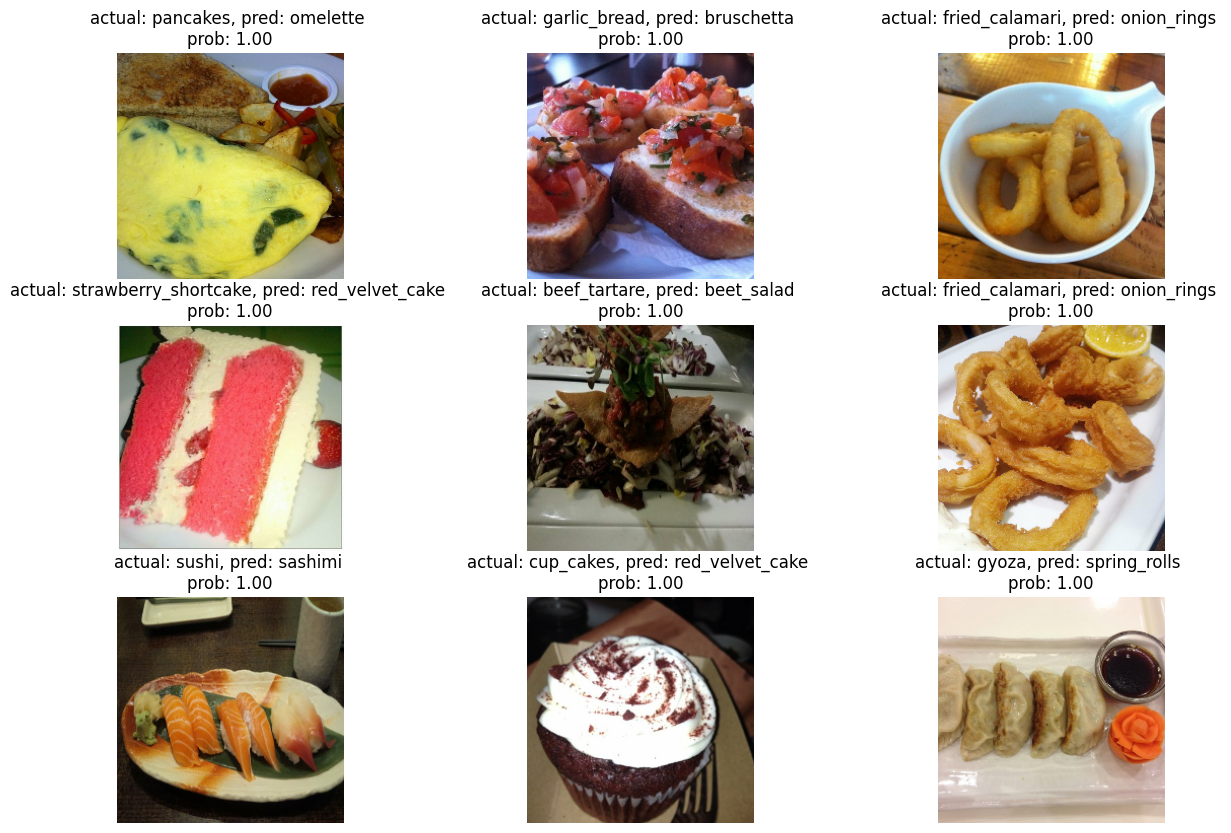

In [ ]:
# Visualize some of the most wrong examples
#images_to_view = 9
start_index += 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index - 10:start_index].itertuples()):
  plt.subplot(3, 3, i+1) # subplot starts with index 1
  img = load_and_prep_img(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

That's it